### Analyze correlation functions:
* Lets load the data stored in CSV files for JC and Motz chains and try to understand whats going on

In [1]:
import numpy as np
import ast
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

from joblib import Parallel, delayed
import pandas as pd
import time

import scipy as sp
from scipy import linalg
import pickle

from JC_functions import *

In [77]:
N_list = [10, 30, 100, 200, 800]
theta_list = [3*np.sqrt(np.pi)/i for i in range(1,10)]

In [92]:
dfZ = pd.read_csv('correlation_data/ZZ.csv', names=['dict', 'x_data', 'Z_data'],)
dfX = pd.read_csv('correlation_data/XX.csv', names=['dict', 'x_data', 'X_data'],)

dfZMotz = pd.read_csv('correlation_data/ZZMotz.csv', names=['dict', 'x_data', 'Z_data'],)
dfXMotz = pd.read_csv('correlation_data/XXMotz.csv', names=['dict', 'x_data', 'X_data'],)

## We stored everything in dataframe so lets define function so we quickly access the data:

In [46]:
def get_list_values(column_value):
    
    """
    Convvert a string array to actual array for first elt in a pd.Series
    """
    
    return ast.literal_eval(str(column_value.values[0]))

In [83]:
JC_keys = dfZ['dict'].values # array of (theta, N) vals
Motz_keys = dfZMotz['dict'].values # array of N vals

# use ast.literal_eval(JC_keys[14]) to convert string to list of numbers 

## Before looking at all the data I want to point out something interesting:
* Lets look an example of meta stability and see how/if it shows up in correlation fcns
* Consider chain with $\theta = 3 \sqrt{\pi}$ for sizes $N=30, 800$

In [26]:
key30 = ast.literal_eval(JC_keys[1]) 
key800 = ast.literal_eval(JC_keys[4])

[5.317361552716548, 800]

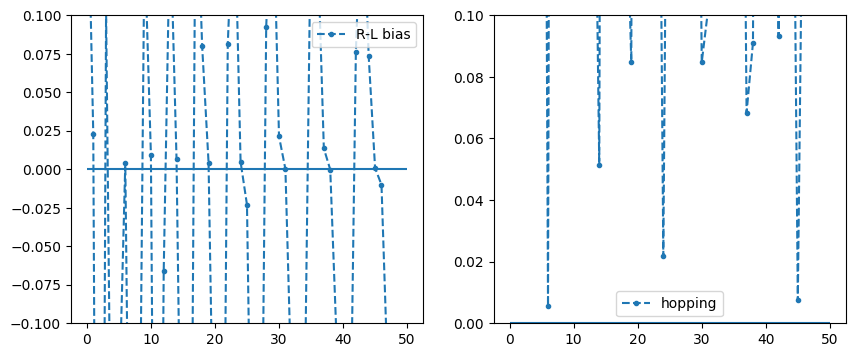

In [75]:
theta = key30[0]
bias, hopp = [[], []]
for n in range(50):
    P = Hop_prob(n,theta)
    bias.append(P[2]-P[0])
    hopp.append(1-P[1])
   
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))

ax1.plot(bias, '.--', label='R-L bias')
ax1.hlines(0,0, 50)
ax1.legend()
ax1.set_ybound(-.1,.1)
ax2.plot(hopp, '.--', label = 'hopping')
ax2.hlines(0,0, 50)
ax2.set_ybound(0,.1)
ax2.legend()

Lets look entanglement:

In [126]:
L_max0, L_max1 = [800, 30]
L_data0, L_data1 = [range(3, L_max0-3, int(L_max0/40)), range(3, L_max1-3, int(L_max1/20))]

L_data2 = list(L_data1)

for n in range(50, L_max1-3, int(L_max1/20)):
    L_data2.append(n)

SE_data0 = [L_data2, [SE_fromM([M_JC(70, theta) for i in range(L_max0)], l) for l in L_data2]]
SE_data1 = [L_data1, [SE_fromM([M_JC(70, theta) for i in range(L_max1)], l) for l in L_data1]]

In [103]:
x_list30 = get_list_values(dfZ[dfZ['dict']==JC_keys[1]]['x_data'])[1:]
ZZ_list30 = get_list_values(dfZ[dfZ['dict']==JC_keys[1]]['Z_data'])[1:]
XX_list30 = get_list_values(dfX[dfX['dict']==JC_keys[1]]['X_data'])[1:]

x_list800 = get_list_values(dfZ[dfZ['dict']==JC_keys[4]]['x_data'])[1:]
ZZ_list800 = get_list_values(dfZ[dfZ['dict']==JC_keys[4]]['Z_data'])[1:]
XX_list800 = get_list_values(dfX[dfX['dict']==JC_keys[4]]['X_data'])[1:]

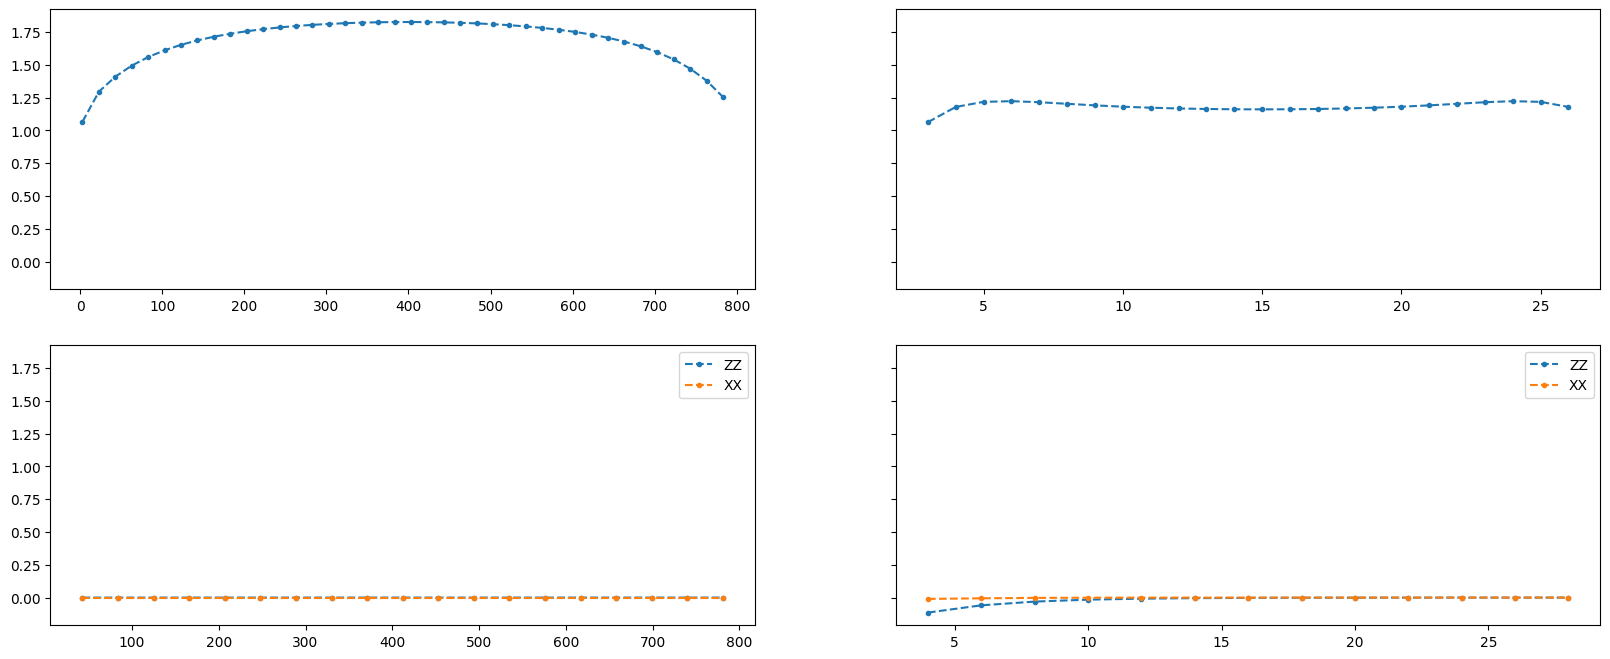

In [108]:
fig, axs = plt.subplots(2,2, figsize = (20,8), sharey=True)
axs[0,0].plot(SE_data0[0], SE_data0[1], '.--', label = 'SE for 800')
axs[0,1].plot(SE_data1[0], SE_data1[1], '.--', label = 'SE for 30')

axs[1,0].plot(x_list800,ZZ_list800, '.--', label = 'ZZ')
axs[1,0].plot(x_list800,XX_list800, '.--', label = 'XX')
axs[1,0].legend()

axs[1,1].plot(x_list30,ZZ_list30, '.--',label = 'ZZ')
axs[1,1].plot(x_list30,XX_list30, '.--',label = 'XX')
axs[1,1].legend()

# Entanglement not reflected in correlation functions

## What we want to compare is the behavior of the correaltion fcns, the trapping and the entropy

* Lets plot fixed theta for different system sizes N

In [101]:
XX_dic, ZZ_dic, XXMotz_dic, ZZMotz_dic = [{},{},{},{}]

for key in JC_keys:
    theta, N = ast.literal_eval(key)

    ZZ_dic[theta, N] = [get_list_values(dfZ[dfZ['dict']==key]['x_data'])[1:], get_list_values(dfZ[dfZ['dict']==key]['Z_data'])[1:] ] 
    XX_dic[theta, N] = [get_list_values(dfX[dfX['dict']==key]['x_data'])[1:], get_list_values(dfX[dfX['dict']==key]['X_data'])[1:] ] 

for key in Motz_keys:
    N = key

    ZZMotz_dic[N] = [get_list_values(dfZMotz[dfZMotz['dict']==key]['x_data'])[1:], get_list_values(dfZMotz[dfZMotz['dict']==key]['Z_data'])[1:] ] 
    XXMotz_dic[N] = [get_list_values(dfZMotz[dfZMotz['dict']==key]['x_data'])[1:], get_list_values(dfXMotz[dfXMotz['dict']==key]['X_data'])[1:] ] 


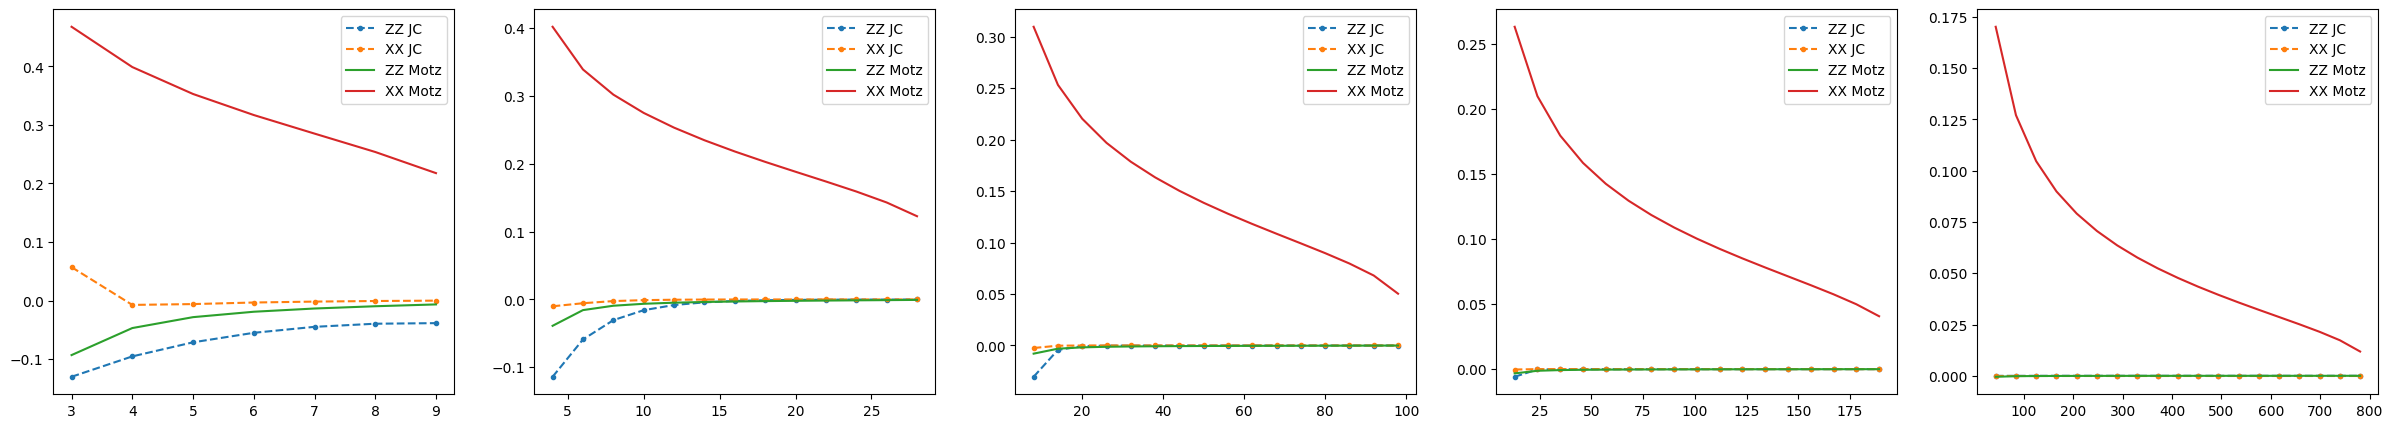

In [107]:
theta = theta_list[0]

fig, axs = plt.subplots(1, len(N_list), figsize = (30,5))
for n,N in enumerate(N_list):

    axs[n].plot(ZZ_dic[theta,N][0], ZZ_dic[theta,N][1],'.--', label = 'ZZ JC')
    axs[n].plot(XX_dic[theta,N][0], XX_dic[theta,N][1],'.--', label = 'XX JC')

    axs[n].plot(ZZMotz_dic[N][0], ZZMotz_dic[N][1], label = 'ZZ Motz')
    axs[n].plot(XXMotz_dic[N][0], XXMotz_dic[N][1], label = 'XX Motz')
    axs[n].legend()




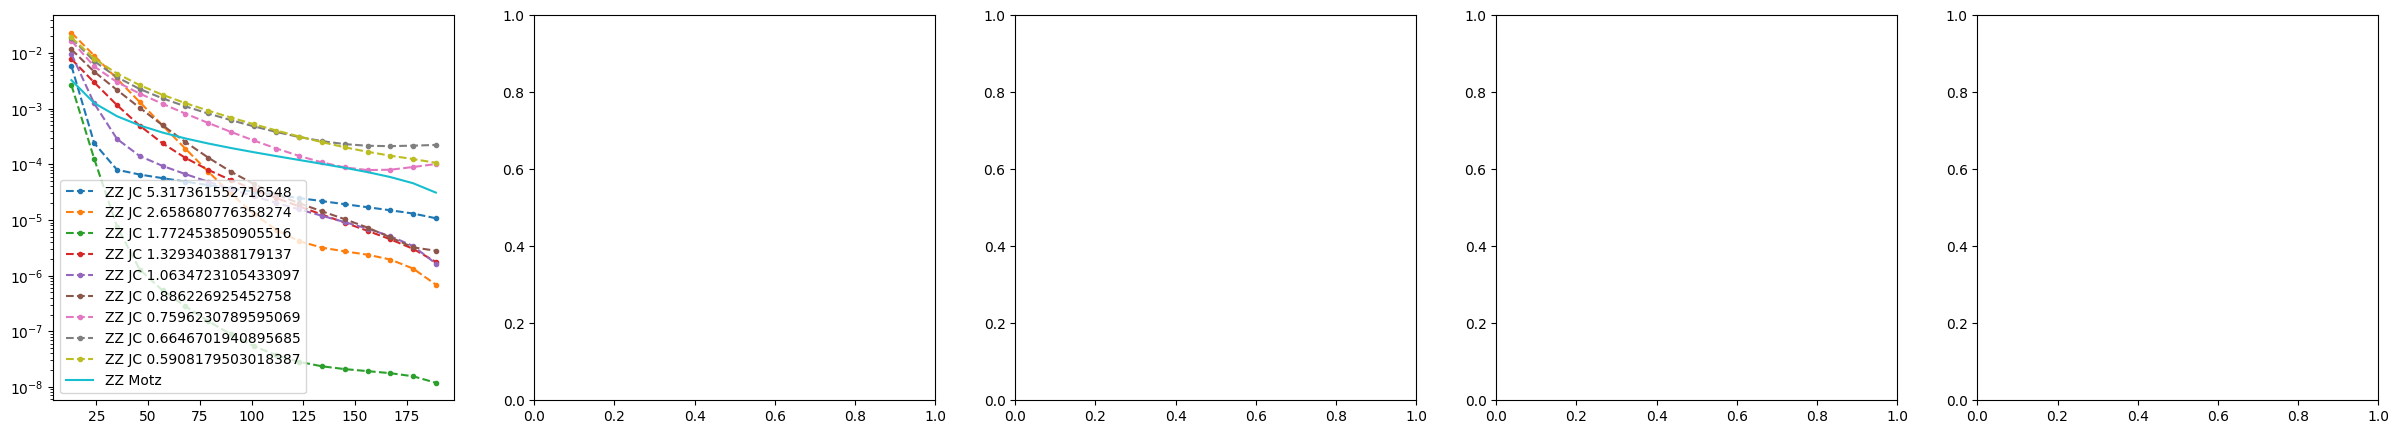

In [120]:
fig, axs = plt.subplots(1, len(N_list), figsize = (30,5))
for n,N in enumerate(N_list):
    for theta in theta_list:

        axs[n].plot(ZZ_dic[theta,N][0], -np.array(ZZ_dic[theta,N][1]),'.--', label = f'ZZ JC {theta}')
        #axs[n].plot(XX_dic[theta,N][0], XX_dic[theta,N][1],'.--', label = 'XX JC')

    axs[n].plot(ZZMotz_dic[N][0], -np.array(ZZMotz_dic[N][1]), label = 'ZZ Motz')
        #axs[n].plot(XXMotz_dic[N][0], XXMotz_dic[N][1], label = 'XX Motz')
    axs[n].legend()
    axs[n].set_yscale('log')

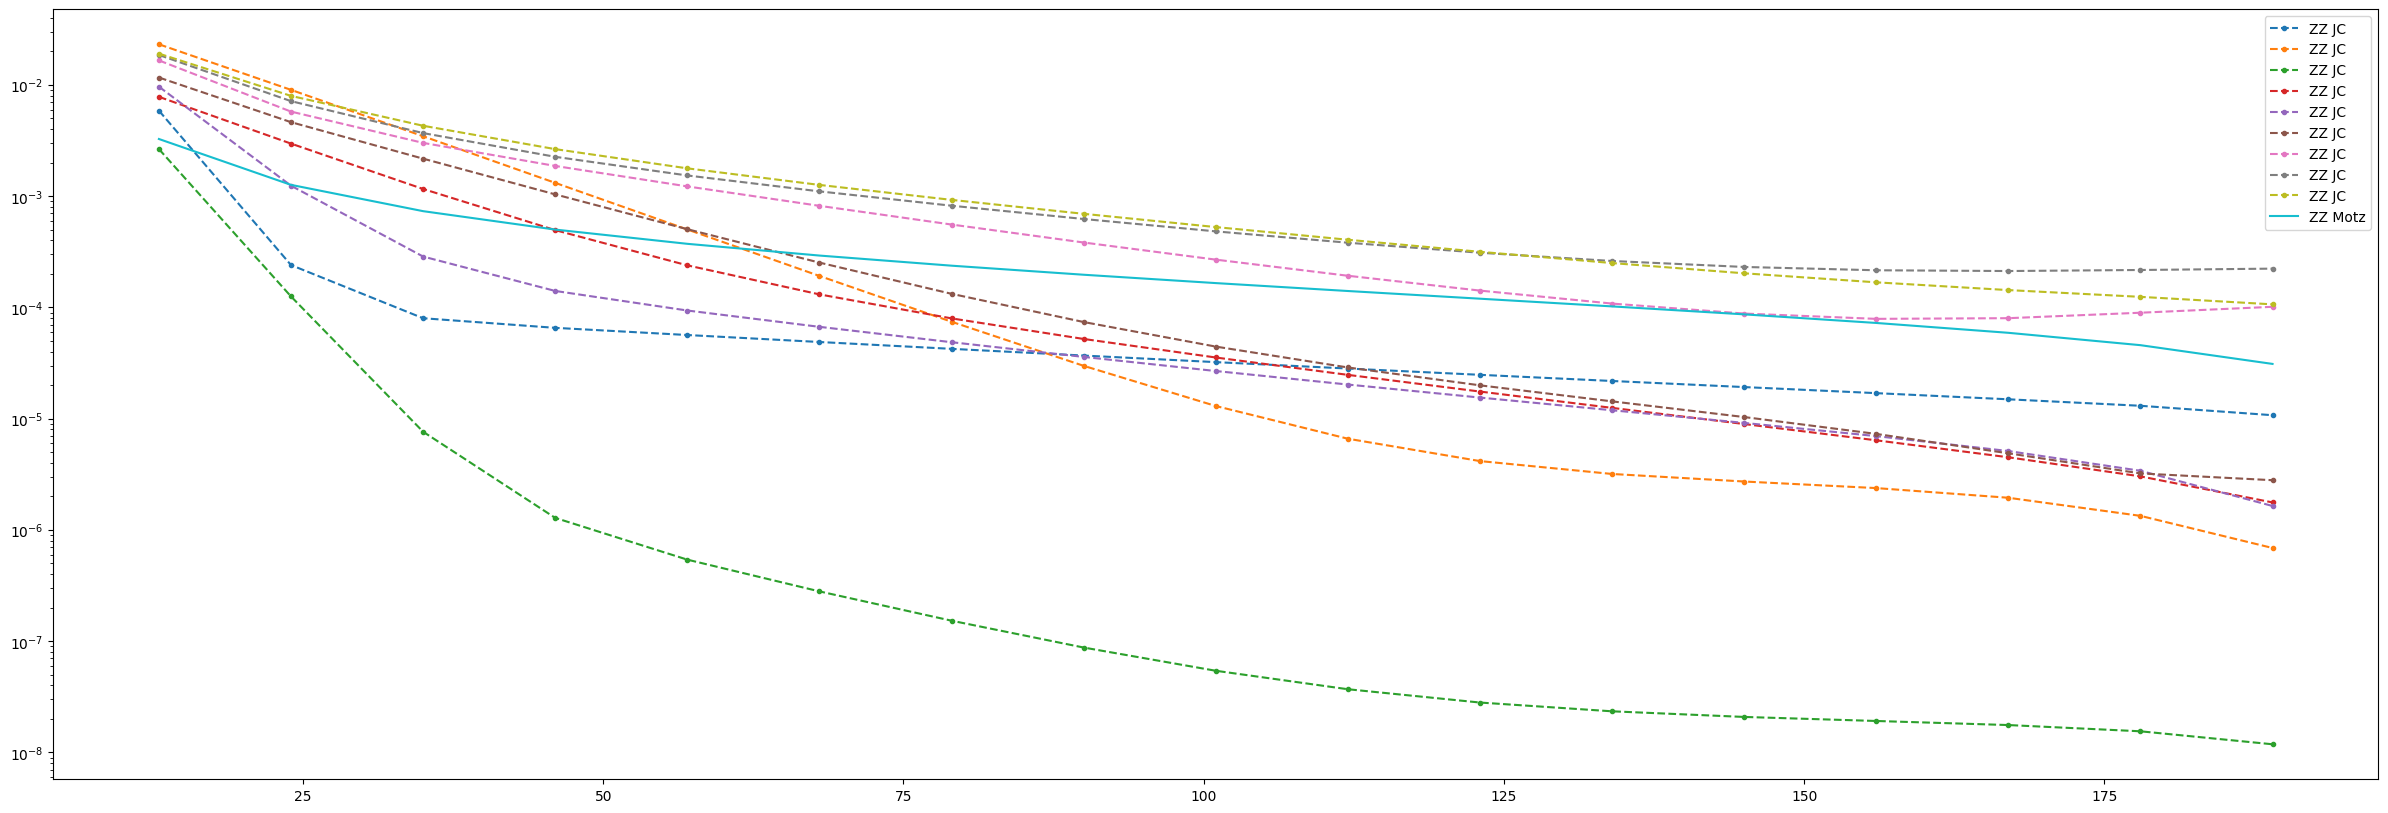

In [125]:
plt.figure(figsize=(30,10))
for theta in theta_list:

    plt.plot(ZZ_dic[theta,N][0], -np.array(ZZ_dic[theta,N][1]),'.--', label = f'ZZ JC')
    #plt.plot(XX_dic[theta,N][0], XX_dic[theta,N][1],'.--', label = 'XX JC')

plt.plot(ZZMotz_dic[N][0], -np.array(ZZMotz_dic[N][1]), label = 'ZZ Motz')
    #plt.plot(XXMotz_dic[N][0], XXMotz_dic[N][1], label = 'XX Motz')
plt.legend()
plt.yscale('log')

In [ ]:
Xspin1